In [121]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim
import folium
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [5]:
CLIENT_ID = 'K033RTD5M3BQUSNQC02QU5JWR4W3MTALZRWCTCG4C0KUGRYW' # your Foursquare ID
CLIENT_SECRET = 'YRQWO3XEWAELWKCJFWGKOWLLJNATSWACVRY3WGPWUGGXOXR3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [ ]:
LIMIT = 100
radius = 10000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    10.82302,
    106.62965, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [168]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(8)

,name,categories,lat,lng
0,Seventeen Coffee,Lounge,10.825413,106.629618
1,Sân Golf Tân Sơn Nhất,Golf Course,10.829959,106.649974
2,AEON Supermarket,Supermarket,10.801783,106.618443
3,Celadon City,Park,10.802461,106.618018
4,Lẩu Dê Đức Dưỡng,Vietnamese Restaurant,10.833790,106.644277
5,CGV Cinemas Hoàng Văn Thụ,Multiplex,10.798997,106.659965
6,Hoa Viên Phổ Quang,Beer Garden,10.803630,106.666228
7,Starbucks,Coffee Shop,10.813034,106.662770


In [25]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [66]:
hcm_data = pd.read_csv("HCM_data.csv")
hcm_data.head()

,District,lat,lng
0,District 1,10.774540,106.699184
1,District 2,10.791116,106.736729
2,District 3,10.783529,106.687098
3,District 4,10.759243,106.704890
4,District 5,10.755840,106.660016


In [77]:
hcm_location = [10.82302, 106.62965]
map_hcm = folium.Map(location=hcm_location, zoom_start=10)

# add markers to map
for lat, lng, district in zip(hcm_data['lat'], hcm_data['lng'], hcm_data['District']):
    label = '{},HCM'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  
    
map_hcm

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
hcm_venues = getNearbyVenues(names=hcm_data['District'],
                                   latitudes=hcm_data['lat'],
                                   longitudes=hcm_data['lng']
                                  )

District 2
District 3
District 4
District 5
District 6
District 7
District 8
District 9
District 10
District 11
District 12
Go Vap
Tan Binh
Tan Phu
Binh Thanh
Binh Tan
Phu Nhuan
Thu Duc


In [181]:
print(np.shape(hcm_venues))
hcm_venues.head()


(1854, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,District 1,10.77454,106.699184,Pizza 4P's,10.773301,106.697599,Pizza Place
1,District 1,10.77454,106.699184,Pasteur Street Brewing Company,10.775220,106.700894,Brewery
2,District 1,10.77454,106.699184,Park Hyatt Saigon,10.777574,106.703609,Hotel
3,District 1,10.77454,106.699184,Silverland Yen Hotel,10.774850,106.696160,Hotel
4,District 1,10.77454,106.699184,Takashimaya,10.773194,106.701075,Department Store


In [176]:
hcm_venues["Venue Category"].replace("Café","Coffee Shop",inplace = True)

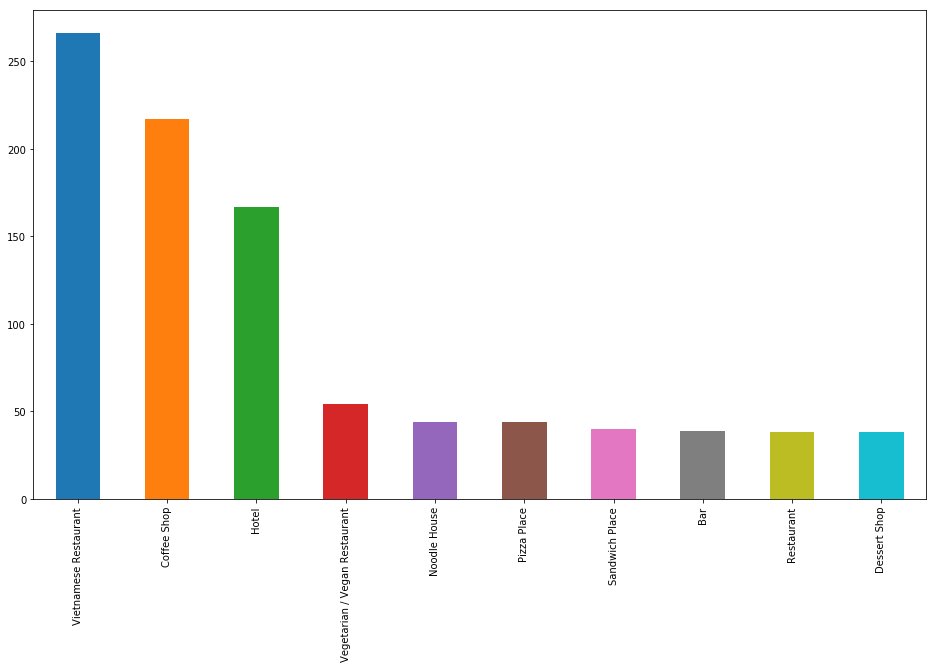

             District Latitude  District Longitude  Venue  Venue Latitude  \
District                                                                    
Binh Tan                   100                 100    100             100   
Binh Thanh                 100                 100    100             100   
District 1                 100                 100    100             100   
District 10                100                 100    100             100   
District 11                100                 100    100             100   
District 12                 85                  85     85              85   
District 2                 100                 100    100             100   
District 3                 100                 100    100             100   
District 4                 100                 100    100             100   
District 5                 100                 100    100             100   
District 6                 100                 100    100             100   

In [205]:
venue_counts = hcm_venues["Venue Category"].value_counts()[0:10]
venue_counts.plot(kind = 'bar',figsize = [16,9])
plt.show()
print(hcm_venues.groupby('District').count())

In [175]:
print('There are {} uniques categories.'.format(len(hcm_venues['Venue Category'].unique())))

There are 103 uniques categories.


In [103]:
hcm_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hcm_onehot['District'] = hcm_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

hcm_onehot.head()

,District,Airport Lounge,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,...,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Toll Booth,Travel Agency,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint
0,District 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,District 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,District 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,District 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,District 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
hcm_onehot.shape

(1854, 104)

In [126]:
hcm_grouped =hcm_onehot.groupby('District').mean().reset_index()

----Binh Tan----


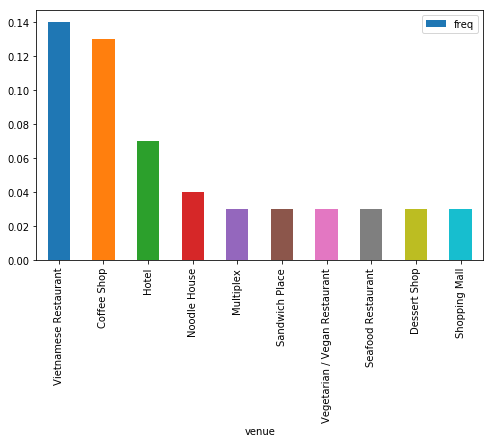



                           venue  freq
0          Vietnamese Restaurant  0.14
1                    Coffee Shop  0.13
2                          Hotel  0.07
3                   Noodle House  0.04
4                      Multiplex  0.03
5                 Sandwich Place  0.03
6  Vegetarian / Vegan Restaurant  0.03
7             Seafood Restaurant  0.03
8                   Dessert Shop  0.03
9                  Shopping Mall  0.03


----Binh Thanh----


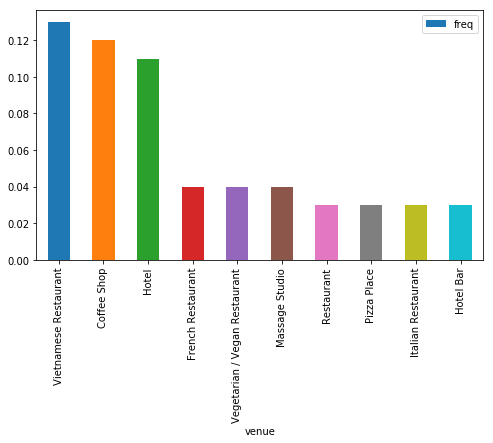



                           venue  freq
0          Vietnamese Restaurant  0.13
1                    Coffee Shop  0.12
2                          Hotel  0.11
3              French Restaurant  0.04
4  Vegetarian / Vegan Restaurant  0.04
5                 Massage Studio  0.04
6                     Restaurant  0.03
7                    Pizza Place  0.03
8             Italian Restaurant  0.03
9                      Hotel Bar  0.03


----District 1----


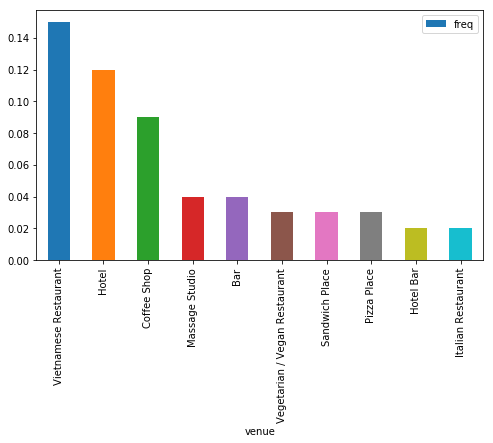



                           venue  freq
0          Vietnamese Restaurant  0.15
1                          Hotel  0.12
2                    Coffee Shop  0.09
3                 Massage Studio  0.04
4                            Bar  0.04
5  Vegetarian / Vegan Restaurant  0.03
6                 Sandwich Place  0.03
7                    Pizza Place  0.03
8                      Hotel Bar  0.02
9             Italian Restaurant  0.02


----District 10----


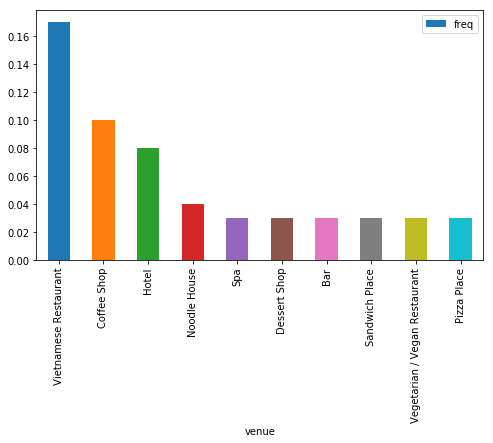



                           venue  freq
0          Vietnamese Restaurant  0.17
1                    Coffee Shop  0.10
2                          Hotel  0.08
3                   Noodle House  0.04
4                            Spa  0.03
5                   Dessert Shop  0.03
6                            Bar  0.03
7                 Sandwich Place  0.03
8  Vegetarian / Vegan Restaurant  0.03
9                    Pizza Place  0.03


----District 11----


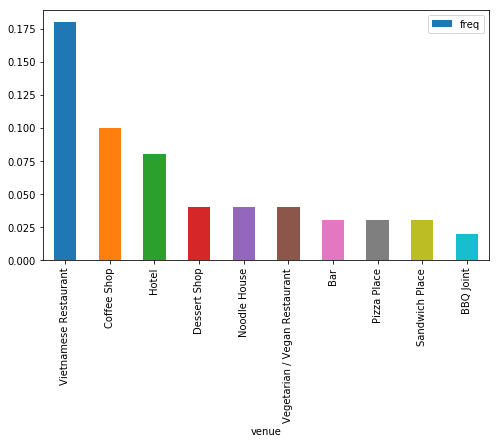



                           venue  freq
0          Vietnamese Restaurant  0.18
1                    Coffee Shop  0.10
2                          Hotel  0.08
3                   Dessert Shop  0.04
4                   Noodle House  0.04
5  Vegetarian / Vegan Restaurant  0.04
6                            Bar  0.03
7                    Pizza Place  0.03
8                 Sandwich Place  0.03
9                      BBQ Joint  0.02


----District 12----


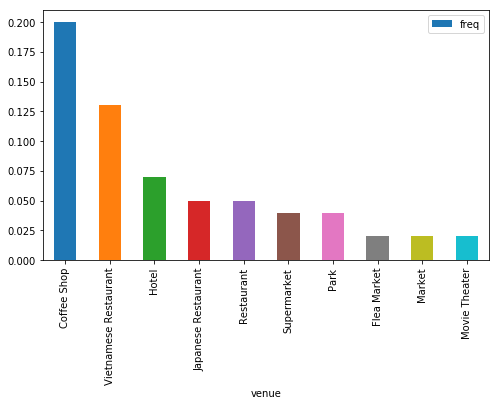



                   venue  freq
0            Coffee Shop  0.20
1  Vietnamese Restaurant  0.13
2                  Hotel  0.07
3    Japanese Restaurant  0.05
4             Restaurant  0.05
5            Supermarket  0.04
6                   Park  0.04
7            Flea Market  0.02
8                 Market  0.02
9          Movie Theater  0.02


----District 2----


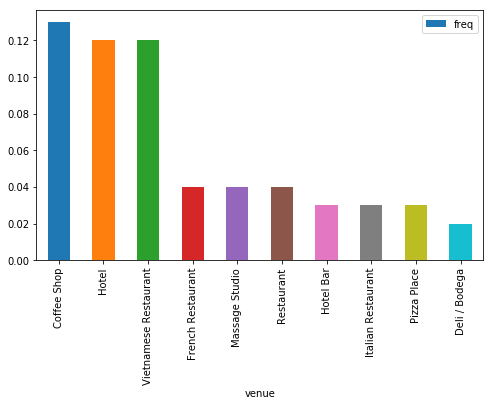



                   venue  freq
0            Coffee Shop  0.13
1                  Hotel  0.12
2  Vietnamese Restaurant  0.12
3      French Restaurant  0.04
4         Massage Studio  0.04
5             Restaurant  0.04
6              Hotel Bar  0.03
7     Italian Restaurant  0.03
8            Pizza Place  0.03
9          Deli / Bodega  0.02


----District 3----


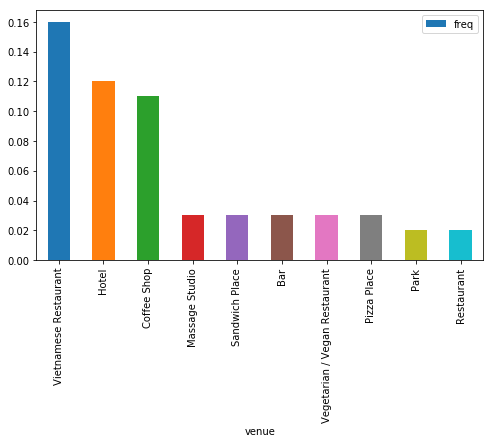



                           venue  freq
0          Vietnamese Restaurant  0.16
1                          Hotel  0.12
2                    Coffee Shop  0.11
3                 Massage Studio  0.03
4                 Sandwich Place  0.03
5                            Bar  0.03
6  Vegetarian / Vegan Restaurant  0.03
7                    Pizza Place  0.03
8                           Park  0.02
9                     Restaurant  0.02


----District 4----


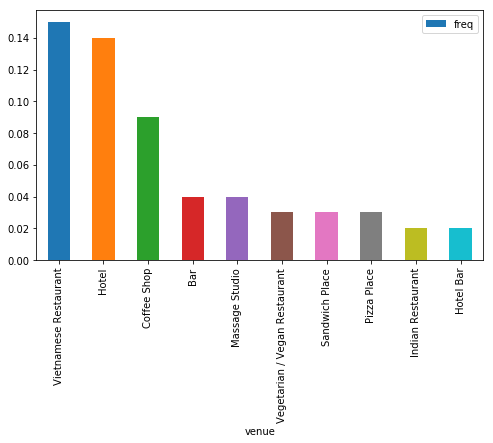



                           venue  freq
0          Vietnamese Restaurant  0.15
1                          Hotel  0.14
2                    Coffee Shop  0.09
3                            Bar  0.04
4                 Massage Studio  0.04
5  Vegetarian / Vegan Restaurant  0.03
6                 Sandwich Place  0.03
7                    Pizza Place  0.03
8              Indian Restaurant  0.02
9                      Hotel Bar  0.02


----District 5----


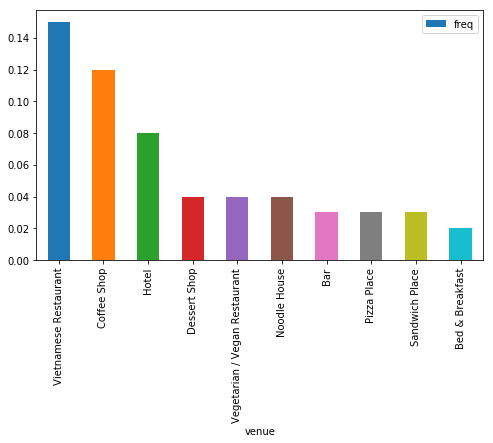



                           venue  freq
0          Vietnamese Restaurant  0.15
1                    Coffee Shop  0.12
2                          Hotel  0.08
3                   Dessert Shop  0.04
4  Vegetarian / Vegan Restaurant  0.04
5                   Noodle House  0.04
6                            Bar  0.03
7                    Pizza Place  0.03
8                 Sandwich Place  0.03
9                Bed & Breakfast  0.02


----District 6----


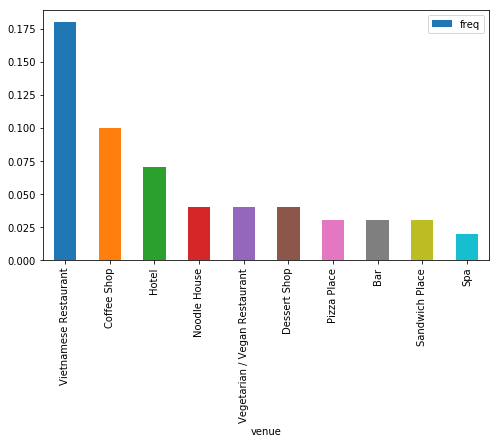



                           venue  freq
0          Vietnamese Restaurant  0.18
1                    Coffee Shop  0.10
2                          Hotel  0.07
3                   Noodle House  0.04
4  Vegetarian / Vegan Restaurant  0.04
5                   Dessert Shop  0.04
6                    Pizza Place  0.03
7                            Bar  0.03
8                 Sandwich Place  0.03
9                            Spa  0.02


----District 7----


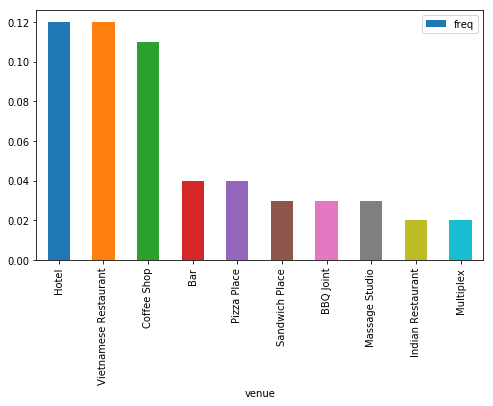



                   venue  freq
0                  Hotel  0.12
1  Vietnamese Restaurant  0.12
2            Coffee Shop  0.11
3                    Bar  0.04
4            Pizza Place  0.04
5         Sandwich Place  0.03
6              BBQ Joint  0.03
7         Massage Studio  0.03
8      Indian Restaurant  0.02
9              Multiplex  0.02


----District 8----


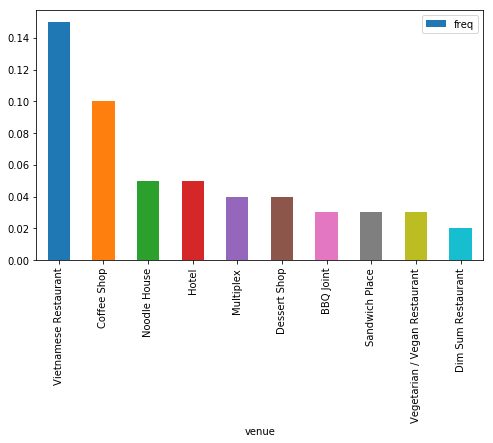



                           venue  freq
0          Vietnamese Restaurant  0.15
1                    Coffee Shop  0.10
2                   Noodle House  0.05
3                          Hotel  0.05
4                      Multiplex  0.04
5                   Dessert Shop  0.04
6                      BBQ Joint  0.03
7                 Sandwich Place  0.03
8  Vegetarian / Vegan Restaurant  0.03
9             Dim Sum Restaurant  0.02


----District 9----


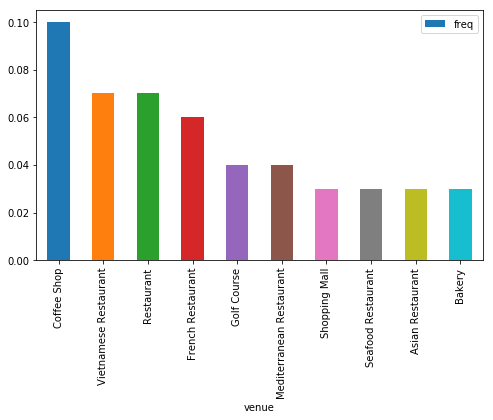



                      venue  freq
0               Coffee Shop  0.10
1     Vietnamese Restaurant  0.07
2                Restaurant  0.07
3         French Restaurant  0.06
4               Golf Course  0.04
5  Mediterranean Restaurant  0.04
6             Shopping Mall  0.03
7        Seafood Restaurant  0.03
8          Asian Restaurant  0.03
9                    Bakery  0.03


----Go Vap----


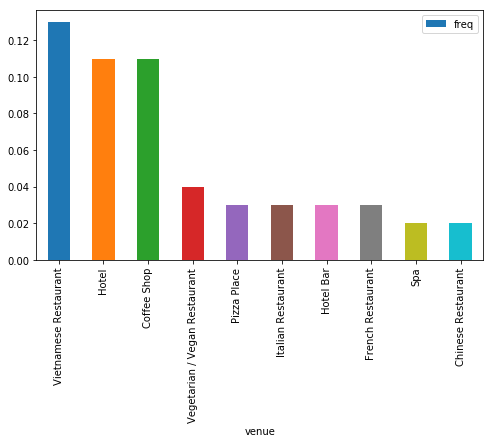



                           venue  freq
0          Vietnamese Restaurant  0.13
1                          Hotel  0.11
2                    Coffee Shop  0.11
3  Vegetarian / Vegan Restaurant  0.04
4                    Pizza Place  0.03
5             Italian Restaurant  0.03
6                      Hotel Bar  0.03
7              French Restaurant  0.03
8                            Spa  0.02
9             Chinese Restaurant  0.02


----Phu Nhuan----


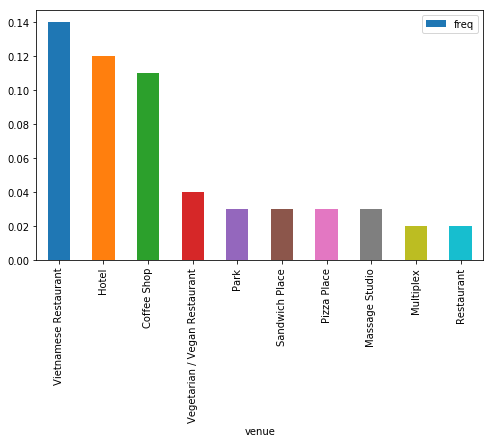



                           venue  freq
0          Vietnamese Restaurant  0.14
1                          Hotel  0.12
2                    Coffee Shop  0.11
3  Vegetarian / Vegan Restaurant  0.04
4                           Park  0.03
5                 Sandwich Place  0.03
6                    Pizza Place  0.03
7                 Massage Studio  0.03
8                      Multiplex  0.02
9                     Restaurant  0.02


----Tan Binh----


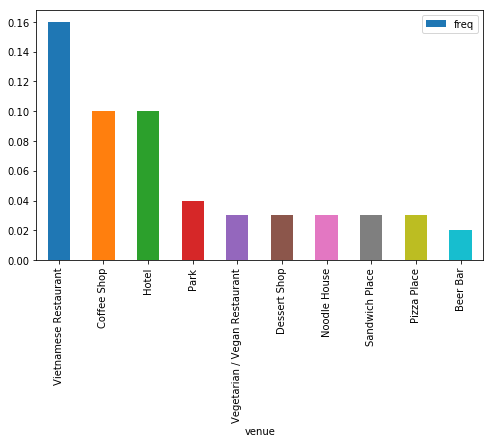



                           venue  freq
0          Vietnamese Restaurant  0.16
1                    Coffee Shop  0.10
2                          Hotel  0.10
3                           Park  0.04
4  Vegetarian / Vegan Restaurant  0.03
5                   Dessert Shop  0.03
6                   Noodle House  0.03
7                 Sandwich Place  0.03
8                    Pizza Place  0.03
9                       Beer Bar  0.02


----Tan Phu----


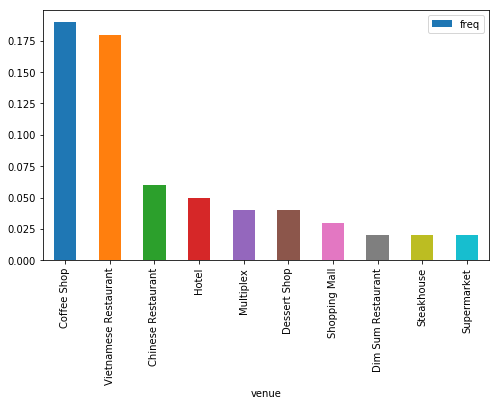



                   venue  freq
0            Coffee Shop  0.19
1  Vietnamese Restaurant  0.18
2     Chinese Restaurant  0.06
3                  Hotel  0.05
4              Multiplex  0.04
5           Dessert Shop  0.04
6          Shopping Mall  0.03
7     Dim Sum Restaurant  0.02
8             Steakhouse  0.02
9            Supermarket  0.02


----Thu Duc----


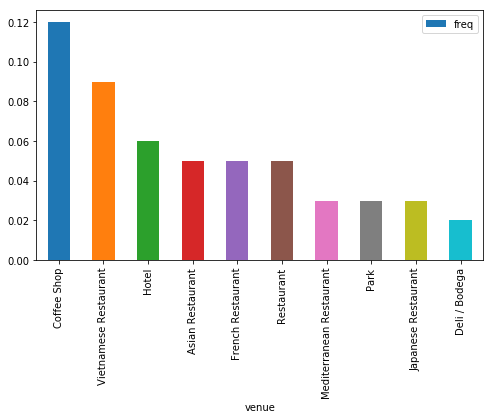



                      venue  freq
0               Coffee Shop  0.12
1     Vietnamese Restaurant  0.09
2                     Hotel  0.06
3          Asian Restaurant  0.05
4         French Restaurant  0.05
5                Restaurant  0.05
6  Mediterranean Restaurant  0.03
7                      Park  0.03
8       Japanese Restaurant  0.03
9             Deli / Bodega  0.02




In [174]:
num_top_venues = 10

for hood in hcm_grouped['District']:
    print("----"+hood+"----")
    temp = hcm_grouped[hcm_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    top_10 = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    temp_venue_list = (top_10["venue"].values.tolist())
    top_10.plot('venue','freq',kind = "bar",figsize = [8,4.6])
    plt.show()
    print('\n')
    print(top_10)
    print('\n')

In [107]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [197]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
District_venues_sorted = pd.DataFrame(columns=columns)
District_venues_sorted['District'] = hcm_grouped['District']

for ind in np.arange(hcm_grouped.shape[0]):
    District_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)

District_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Binh Tan,Vietnamese Restaurant,Coffee Shop,Hotel,Noodle House,Sandwich Place,Vegetarian / Vegan Restaurant,Dessert Shop,Multiplex,Seafood Restaurant,Shopping Mall
1,Binh Thanh,Vietnamese Restaurant,Coffee Shop,Hotel,Vegetarian / Vegan Restaurant,Massage Studio,French Restaurant,Italian Restaurant,Restaurant,Hotel Bar,Pizza Place
2,District 1,Vietnamese Restaurant,Hotel,Coffee Shop,Massage Studio,Bar,Vegetarian / Vegan Restaurant,Pizza Place,Sandwich Place,Whisky Bar,Multiplex
3,District 10,Vietnamese Restaurant,Coffee Shop,Hotel,Noodle House,Pizza Place,Bar,Dessert Shop,Spa,Sandwich Place,Vegetarian / Vegan Restaurant
4,District 11,Vietnamese Restaurant,Coffee Shop,Hotel,Vegetarian / Vegan Restaurant,Noodle House,Dessert Shop,Sandwich Place,Pizza Place,Bar,Bed & Breakfast


In [198]:
kclusters = 5

hcm_grouped_clustering = hcm_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hcm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 4, 1, 3, 3, 0, 4, 1, 1, 3])

In [199]:
District_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hcm_merged = hcm_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
hcm_merged = hcm_merged.join(District_venues_sorted.set_index('District'), on='District')

hcm_merged.head() # check the last columns!

,District,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,District 1,10.774540,106.699184,1,Vietnamese Restaurant,Hotel,Coffee Shop,Massage Studio,Bar,Vegetarian / Vegan Restaurant,Pizza Place,Sandwich Place,Whisky Bar,Multiplex
1,District 2,10.791116,106.736729,4,Coffee Shop,Hotel,Vietnamese Restaurant,Massage Studio,French Restaurant,Restaurant,Hotel Bar,Italian Restaurant,Pizza Place,Chinese Restaurant
2,District 3,10.783529,106.687098,1,Vietnamese Restaurant,Hotel,Coffee Shop,Vegetarian / Vegan Restaurant,Sandwich Place,Pizza Place,Massage Studio,Bar,Park,Italian Restaurant
3,District 4,10.759243,106.704890,1,Vietnamese Restaurant,Hotel,Coffee Shop,Bar,Massage Studio,Pizza Place,Vegetarian / Vegan Restaurant,Sandwich Place,Multiplex,Bed & Breakfast
4,District 5,10.755840,106.660016,3,Vietnamese Restaurant,Coffee Shop,Hotel,Noodle House,Vegetarian / Vegan Restaurant,Dessert Shop,Sandwich Place,Bar,Pizza Place,BBQ Joint


In [200]:
map_clusters = folium.Map(location=hcm_location, zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, poi, cluster in zip(hcm_merged['lat'], hcm_merged['lng'], hcm_merged['District'],hcm_merged["Cluster Labels"]):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        cluster = int(cluster)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
# add markers to the map
markers_colors = []
map_clusters

In [112]:
hcm_merged.loc[hcm_merged['Cluster Labels'] == 0, hcm_merged.columns[[0] + list(range(4, hcm_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,District 12,Coffee Shop,Vietnamese Restaurant,Hotel,Japanese Restaurant,Restaurant,Supermarket,Park,Flea Market,Diner,Seafood Restaurant
14,Tan Phu,Coffee Shop,Vietnamese Restaurant,Chinese Restaurant,Hotel,Dessert Shop,Multiplex,Shopping Mall,Steakhouse,Supermarket,Seafood Restaurant


In [113]:
hcm_merged.loc[hcm_merged['Cluster Labels'] == 1, hcm_merged.columns[[0] + list(range(4, hcm_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,District 1,Vietnamese Restaurant,Hotel,Coffee Shop,Massage Studio,Bar,Vegetarian / Vegan Restaurant,Pizza Place,Sandwich Place,Whisky Bar,Multiplex
2,District 3,Vietnamese Restaurant,Hotel,Coffee Shop,Vegetarian / Vegan Restaurant,Sandwich Place,Pizza Place,Massage Studio,Bar,Park,Italian Restaurant
3,District 4,Vietnamese Restaurant,Hotel,Coffee Shop,Bar,Massage Studio,Pizza Place,Vegetarian / Vegan Restaurant,Sandwich Place,Multiplex,Bed & Breakfast
6,District 7,Vietnamese Restaurant,Hotel,Coffee Shop,Pizza Place,Bar,BBQ Joint,Sandwich Place,Massage Studio,Multiplex,Bed & Breakfast
17,Phu Nhuan,Vietnamese Restaurant,Hotel,Coffee Shop,Vegetarian / Vegan Restaurant,Pizza Place,Sandwich Place,Massage Studio,Park,Noodle House,Asian Restaurant


In [114]:
hcm_merged.loc[hcm_merged['Cluster Labels'] == 2, hcm_merged.columns[[0] + list(range(4, hcm_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,District 9,Coffee Shop,Vietnamese Restaurant,Restaurant,French Restaurant,Mediterranean Restaurant,Golf Course,Bakery,Shopping Mall,Seafood Restaurant,Deli / Bodega
18,Thu Duc,Coffee Shop,Vietnamese Restaurant,Hotel,French Restaurant,Restaurant,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Park,Bakery


In [115]:
hcm_merged.loc[hcm_merged['Cluster Labels'] == 3, hcm_merged.columns[[0] + list(range(4, hcm_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,District 5,Vietnamese Restaurant,Coffee Shop,Hotel,Noodle House,Vegetarian / Vegan Restaurant,Dessert Shop,Sandwich Place,Bar,Pizza Place,BBQ Joint
5,District 6,Vietnamese Restaurant,Coffee Shop,Hotel,Noodle House,Vegetarian / Vegan Restaurant,Dessert Shop,Sandwich Place,Bar,Pizza Place,BBQ Joint
7,District 8,Vietnamese Restaurant,Coffee Shop,Hotel,Noodle House,Multiplex,Dessert Shop,Vegetarian / Vegan Restaurant,Sandwich Place,BBQ Joint,Pizza Place
9,District 10,Vietnamese Restaurant,Coffee Shop,Hotel,Noodle House,Pizza Place,Bar,Dessert Shop,Spa,Sandwich Place,Vegetarian / Vegan Restaurant
10,District 11,Vietnamese Restaurant,Coffee Shop,Hotel,Vegetarian / Vegan Restaurant,Noodle House,Dessert Shop,Sandwich Place,Pizza Place,Bar,Bed & Breakfast
13,Tan Binh,Vietnamese Restaurant,Hotel,Coffee Shop,Park,Pizza Place,Dessert Shop,Noodle House,Sandwich Place,Vegetarian / Vegan Restaurant,Multiplex
16,Binh Tan,Vietnamese Restaurant,Coffee Shop,Hotel,Noodle House,Sandwich Place,Vegetarian / Vegan Restaurant,Dessert Shop,Multiplex,Seafood Restaurant,Shopping Mall


In [116]:
hcm_merged.loc[hcm_merged['Cluster Labels'] == 4, hcm_merged.columns[[0] + list(range(4, hcm_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,District 2,Coffee Shop,Hotel,Vietnamese Restaurant,Massage Studio,French Restaurant,Restaurant,Hotel Bar,Italian Restaurant,Pizza Place,Chinese Restaurant
12,Go Vap,Vietnamese Restaurant,Hotel,Coffee Shop,Vegetarian / Vegan Restaurant,Hotel Bar,Italian Restaurant,French Restaurant,Pizza Place,Spa,Japanese Restaurant
15,Binh Thanh,Vietnamese Restaurant,Coffee Shop,Hotel,Vegetarian / Vegan Restaurant,Massage Studio,French Restaurant,Italian Restaurant,Restaurant,Hotel Bar,Pizza Place
